# Analyse Mumbai Indians in 2019 IPL finals 
Using their performance in 2019 alone. 


By Pitchappan P RM

Objective :

    To predict the win probability of MI at the end of each over for the finals of IPL season 2019.

Training data :
    
    All other matches played during 2019 season 

# Libraries

In [1]:
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 20)

# Load Data and get an idea

In [2]:
data_path = "Data/"
score_df = pd.read_csv(data_path+"deliveries.csv")
match_df = pd.read_csv(data_path+"matches.csv")
score_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


# Lets take 2019 data alone

In [3]:
match_df = match_df.loc[match_df.season==2019,:]
match_df = match_df.loc[match_df.dl_applied == 0,:]
match_df.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
696,11137,2019,Chennai,23/03/19,Royal Challengers Bangalore,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,7,Harbhajan Singh,M. A. Chidambaram Stadium,Bruce Oxenford,Anil Dandekar,Nitin Menon
697,11138,2019,Kolkata,24/03/19,Sunrisers Hyderabad,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,6,AD Russell,Eden Gardens,Chris Gaffaney,Anil Chaudhary,Vineet Kulkarni
698,11139,2019,Mumbai,24/03/19,Delhi Capitals,Mumbai Indians,Mumbai Indians,field,normal,0,Delhi Capitals,37,0,RR Pant,Wankhede Stadium,S Ravi,Yeshwant Barde,O Nandan
699,11140,2019,Jaipur,25/03/19,Kings XI Punjab,Rajasthan Royals,Rajasthan Royals,field,normal,0,Kings XI Punjab,14,0,CH Gayle,Sawai Mansingh Stadium,C Shamshuddin,KN Anantapadmanabhan,Bruce Oxenford
700,11141,2019,Delhi,26/03/19,Delhi Capitals,Chennai Super Kings,Delhi Capitals,bat,normal,0,Chennai Super Kings,0,6,SR Watson,Feroz Shah Kotla Ground,Marais Erasmus,Nitin Menon,Anil Dandekar


# Loading data and processing it is done. Now for Battle Plan

Let us now create the variables that are needed for building our model. 

Some of the important variables which I could think of are the following:

1. Runs scored in the last over
2. Wickets taken in the last over
3. Total score of the innings
4. Total wickets 
5. Target that the team is chasing down
6. Remaining target
7. Run rate
8. Required run rate
9. Difference between run rate and required run rate
10. Binary variables on whether the team for which we are predicting is batting team or bowling team

There are several other variables which we can create including

1. Team name
2. Opponent team name
3. Score in the last 'n' overs
4. Players who are batting
5. Player who is bowling and so on.

But ours is a good set of variables to start with.



In [4]:
# runs and wickets per over #
score_df = pd.merge(score_df, match_df[['id','season', 'winner', 'result', 'dl_applied', 'team1', 'team2']], left_on='match_id', right_on='id')
score_df.player_dismissed.fillna(0, inplace=True)
score_df['player_dismissed'].loc[score_df['player_dismissed'] != 0] = 1
train_df = score_df.groupby(['match_id', 'inning', 'over', 'team1', 'team2', 'batting_team', 'winner'])[['total_runs', 'player_dismissed']].agg(['sum']).reset_index()
train_df.columns = train_df.columns.get_level_values(0)

# innings score and wickets #
train_df['innings_wickets'] = train_df.groupby(['match_id', 'inning'])['player_dismissed'].cumsum()
train_df['innings_score'] = train_df.groupby(['match_id', 'inning'])['total_runs'].cumsum()
train_df.head()

# Get the target column #
temp_df = train_df.groupby(['match_id', 'inning'])['total_runs'].sum().reset_index()
temp_df = temp_df.loc[temp_df['inning']==1,:]
temp_df['inning'] = 2
temp_df.columns = ['match_id', 'inning', 'score_target']
train_df = train_df.merge(temp_df, how='left', on = ['match_id', 'inning'])
train_df['score_target'].fillna(-1, inplace=True)

# get the remaining target #
def get_remaining_target(row):
    if row['score_target'] == -1.:
        return -1
    else:
        return row['score_target'] - row['innings_score']

train_df['remaining_target'] = train_df.apply(lambda row: get_remaining_target(row),axis=1)

# get the run rate #
train_df['run_rate'] = train_df['innings_score'] / train_df['over']

# get the remaining run rate #
def get_required_rr(row):
    if row['remaining_target'] == -1:
        return -1.
    elif row['over'] == 20:
        return 99
    else:
        return row['remaining_target'] / (20-row['over'])
    
train_df['required_run_rate'] = train_df.apply(lambda row: get_required_rr(row), axis=1)

def get_rr_diff(row):
    if row['inning'] == 1:
        return -1
    else:
        return row['run_rate'] - row['required_run_rate']
    
train_df['runrate_diff'] = train_df.apply(lambda row: get_rr_diff(row), axis=1)
train_df['is_batting_team'] = (train_df['team1'] == train_df['batting_team']).astype('int')
train_df['target'] = (train_df['team1'] == train_df['winner']).astype('int')

train_df.tail()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
2313,11415,2,16,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,20,0,4,112,152.0,40.0,7.000000,10.000000,-3.000000,0,1
2314,11415,2,17,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,5,0,4,117,152.0,35.0,6.882353,11.666667,-4.784314,0,1
2315,11415,2,18,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,20,0,4,137,152.0,15.0,7.611111,7.500000,0.111111,0,1
2316,11415,2,19,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,13,1,5,150,152.0,2.0,7.894737,2.000000,5.894737,0,1
2317,11415,2,20,Mumbai Indians,Chennai Super Kings,Chennai Super Kings,Mumbai Indians,7,2,7,157,152.0,-5.0,7.850000,99.000000,-91.150000,0,1


# Let's split data so that we can analyse final match as validation sample

In [5]:
x_cols = ['inning', 'over', 'total_runs', 'player_dismissed', 'innings_wickets', 'innings_score', 'score_target', 'remaining_target', 'run_rate', 'required_run_rate', 'runrate_diff', 'is_batting_team']

# let us take all the matches but for the final as development sample and final as val sample #
val_df = train_df.loc[train_df.match_id == 11415,:]
dev_df = train_df.loc[train_df.match_id != 11415,:]

# create the input and target variables #
dev_X = np.array(dev_df[x_cols[:]])
dev_y = np.array(dev_df['target'])
val_X = np.array(val_df[x_cols[:]])[:-1,:]
val_y = np.array(val_df['target'])[:-1]
print(dev_X.shape, dev_y.shape)
print(val_X.shape, val_y.shape)

(2278, 12) (2278,)
(39, 12) (39,)


In [6]:
val_df

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
2278,11415,1,1,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,2,0,0,2,-1.0,-1.0,2.000000,-1.000000,-1.000000,1,1
2279,11415,1,2,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,0,0,10,-1.0,-1.0,5.000000,-1.000000,-1.000000,1,1
2280,11415,1,3,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,21,0,0,31,-1.0,-1.0,10.333333,-1.000000,-1.000000,1,1
2281,11415,1,4,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,7,0,0,38,-1.0,-1.0,9.500000,-1.000000,-1.000000,1,1
2282,11415,1,5,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,8,1,1,46,-1.0,-1.0,9.200000,-1.000000,-1.000000,1,1
2283,11415,1,6,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,0,1,2,46,-1.0,-1.0,7.666667,-1.000000,-1.000000,1,1
2284,11415,1,7,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,5,0,2,51,-1.0,-1.0,7.285714,-1.000000,-1.000000,1,1
2285,11415,1,8,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,3,0,2,54,-1.0,-1.0,6.750000,-1.000000,-1.000000,1,1
2286,11415,1,9,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,6,0,2,60,-1.0,-1.0,6.666667,-1.000000,-1.000000,1,1
2287,11415,1,10,Mumbai Indians,Chennai Super Kings,Mumbai Indians,Mumbai Indians,13,0,2,73,-1.0,-1.0,7.300000,-1.000000,-1.000000,1,1


In [7]:
dev_df

,match_id,inning,over,team1,team2,batting_team,winner,total_runs,player_dismissed,innings_wickets,innings_score,score_target,remaining_target,run_rate,required_run_rate,runrate_diff,is_batting_team,target
0,11137,1,1,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,5,0,0,5,-1.0,-1.0,5.000000,-1.000000,-1.000000,1,0
1,11137,1,2,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,8,0,0,13,-1.0,-1.0,6.500000,-1.000000,-1.000000,1,0
2,11137,1,3,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,4,0,0,17,-1.0,-1.0,5.666667,-1.000000,-1.000000,1,0
3,11137,1,4,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,7,1,1,24,-1.0,-1.0,6.000000,-1.000000,-1.000000,1,0
4,11137,1,5,Royal Challengers Bangalore,Chennai Super Kings,Royal Challengers Bangalore,Chennai Super Kings,6,0,1,30,-1.0,-1.0,6.000000,-1.000000,-1.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,11414,2,15,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,Chennai Super Kings,4,0,2,125,155.0,30.0,8.333333,6.000000,2.333333,0,0
2274,11414,2,16,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,Chennai Super Kings,8,1,3,133,155.0,22.0,8.312500,5.500000,2.812500,0,0
2275,11414,2,17,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,Chennai Super Kings,8,0,3,141,155.0,14.0,8.294118,4.666667,3.627451,0,0
2276,11414,2,18,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,Chennai Super Kings,10,0,3,151,155.0,4.0,8.388889,2.000000,6.388889,0,0


# I've chosen XGBoost for modelling. 
Let's define a custom function for it

In [8]:
def runXGB(train_X, train_y, seed_val=0):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.05
    param['max_depth'] = 8
    param['silent'] = 1
    param['eval_metric'] = "auc"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = 100

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

# now to build model
dev is for training - all other matches
val is for validation - final match

In [9]:
model = runXGB(dev_X, dev_y)
xgtest = xgb.DMatrix(val_X)
preds = model.predict(xgtest)

# Find factors that contribute to win more

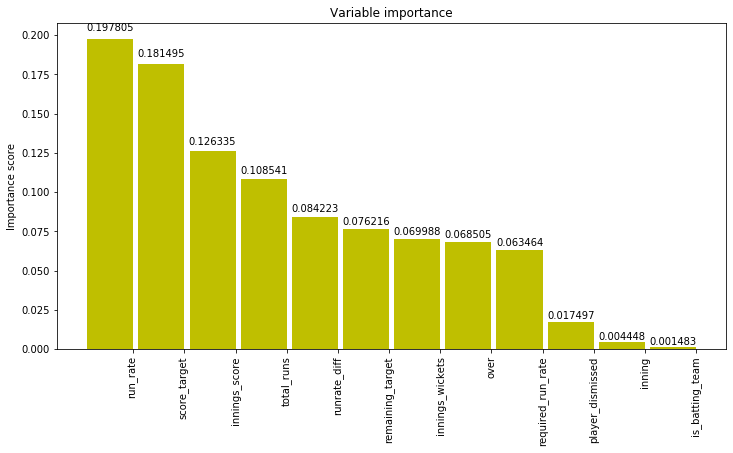

In [10]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

create_feature_map(x_cols)
importance = model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()

# create a function for labeling #
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%f' % float(height),
                ha='center', va='bottom')
        
labels = np.array(imp_df.feature.values)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,6))
rects = ax.bar(ind, np.array(imp_df.fscore.values), width=width, color='y')
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Importance score")
ax.set_title("Variable importance")
autolabel(rects)
plt.show()

# Win probability for MI at the last match

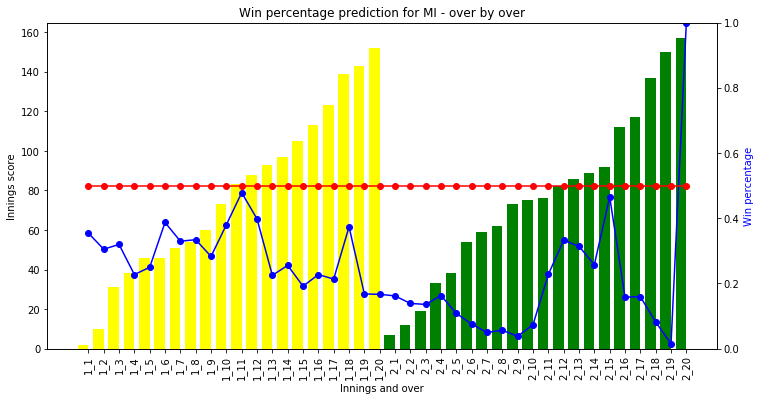

In [11]:
out_df = pd.DataFrame({'Team1':val_df.team1.values})
out_df['is_batting_team'] = val_df.is_batting_team.values
out_df['innings_over'] = np.array(val_df.apply(lambda row: str(row['inning']) + "_" + str(row['over']), axis=1))
out_df['innings_score'] = val_df.innings_score.values
out_df['innings_wickets'] = val_df.innings_wickets.values
out_df['score_target'] = val_df.score_target.values
out_df['total_runs'] = val_df.total_runs.values
out_df['predictions'] = list(preds)+[1]

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['innings_score']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Innings score")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

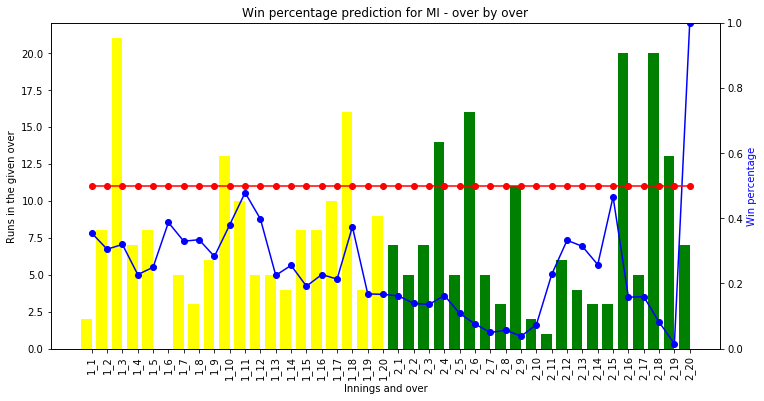

In [12]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
labels = np.array(out_df['innings_over'])
ind = np.arange(len(labels))
width = 0.7
rects = ax1.bar(ind, np.array(out_df['total_runs']), width=width, color=['yellow']*20 + ['green']*20)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Runs in the given over")
ax1.set_xlabel("Innings and over")
ax1.set_title("Win percentage prediction for MI - over by over")

ax2.plot(ind+0.35, np.array(out_df['predictions']), color='b', marker='o')
ax2.plot(ind+0.35, np.array([0.5]*40), color='red', marker='o')
ax2.set_ylabel("Win percentage", color='b')
ax2.set_ylim([0,1])
ax2.grid(b=False)
plt.show()

# Results of above 2 outputs

The red line denotes the 50-50 chance to win and MI were clearly losing, ACCORDING TO THE XGBOOST MODEL, till the last over when CSK failed to take enough runs. This also follows the general sentiment the media gave last year.